In [1]:
df_dist1 <- read.csv(file="eddypro_nogal_full_output_2017.csv", header=TRUE, sep=";", stringsAsFactors=FALSE)

In [2]:
head(df_dist1)

file_info,X,X.1,X.2,X.3,X.4,X.5,corrected_fluxes_and_quality_flags,X.6,X.7,⋯,X.92,X.93,covariances,X.94,X.95,custom_variables,X.96,X.97,X.98,X.99
filename,date,time,DOY,daytime,file_records,used_records,Tau,qc_Tau,H,⋯,co2_var,h2o_var,w/ts_cov,w/co2_cov,w/h2o_cov,vin_sf_mean,co2_mean,h2o_mean,dew_point_mean,co2_signal_strength_7500_mean
,[yyyy-mm-dd],[HH:MM],[ddd.ddd],[1=daytime],[#],[#],[kg+1m-1s-2],[#],[W+1m-2],⋯,--,--,[m+1K+1s-1],--,--,--,--,--,--,--
2017-01-01T003000_AIU-1646.ghg,1/1/17,1:00,1.041,0,18000,18000,0.02,0,-8.16,⋯,1.36E-03,5.502550567,-6.60E-03,9.73E-04,-1.17E-02,11.42559505,407.4435006,12.21165082,9.838440708,100.5692737
2017-01-01T010000_AIU-1646.ghg,1/1/17,1:30,1.062,0,18000,18000,0.01,0,-4.89,⋯,1.39E-02,21.94927353,-3.86E-03,-8.71E-05,2.82E-02,11.41149602,409.1143058,12.1475204,9.760020541,100.4057248
2017-01-01T013000_AIU-1646.ghg,1/1/17,2:00,1.083,0,18000,18000,0.02,1,-33.18,⋯,4.20E-02,82.90077781,-2.62E-02,4.31E-03,-3.72E-02,11.40325816,401.1005444,12.76491439,10.50076129,100.7945015
2017-01-01T020000_AIU-1646.ghg,1/1/17,2:30,1.104,0,18000,18000,0.04,0,-29.50,⋯,1.44E-02,43.2679776,-2.41E-02,4.58E-03,-0.196236759,11.38542792,407.6151216,12.39083745,10.05340433,100.3132022


In [7]:
df <- df_dist1[-c(2), ]

In [45]:
# select variables X.44, X.45, X.46
myvars <- c("X.44", "X.45", "X.46")
df_Wind <- df_dist1[myvars]
df_Wind <- df_Wind[-c(1,2),]
df_Wind[,1:3] <- sapply(df_Wind[,1:3], as.numeric)
df_Wind[df_Wind < -5000] <- NA
df_Wind <- df_Wind[complete.cases(df_Wind), ]
names(df_Wind) <- c("spd", "spd_max", "dir")
str(df_Wind)

'data.frame':	16282 obs. of  3 variables:
 $ spd    : num  1.34 1.11 1.37 1.6 1.51 ...
 $ spd_max: num  2.55 1.96 2.45 3.68 3.4 ...
 $ dir    : num  63.3 35.8 76 88.4 92.8 ...


In [46]:
summary(df_Wind)

      spd            spd_max             dir         
 Min.   :0.0162   Min.   : 0.6002   Min.   :  0.023  
 1st Qu.:1.4473   1st Qu.: 3.1321   1st Qu.: 97.453  
 Median :2.0212   Median : 4.2046   Median :205.938  
 Mean   :2.1038   Mean   : 4.9201   Mean   :183.500  
 3rd Qu.:2.6152   3rd Qu.: 6.2082   3rd Qu.:253.700  
 Max.   :7.9186   Max.   :23.9428   Max.   :359.993  

In [47]:
data <- data.frame(df_Wind)
str(data)

'data.frame':	16282 obs. of  3 variables:
 $ spd    : num  1.34 1.11 1.37 1.6 1.51 ...
 $ spd_max: num  2.55 1.96 2.45 3.68 3.4 ...
 $ dir    : num  63.3 35.8 76 88.4 92.8 ...


In [64]:
install.packages("ggthemes") # Install 


Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [65]:
require(ggplot2)
require(RColorBrewer)
require(ggthemes)

Loading required package: ggthemes


In [66]:
plot.windrose <- function(data,
                      spd,
                      dir,
                      spdres = 1.0,
                      dirres = 30,
                      spdmin = 1,
                      spdmax = 8,
                      spdseq = NULL,
                      palette = "YlGnBu",
                      countmax = NA,
                      debug = 0){


# Look to see what data was passed in to the function
  if (is.numeric(spd) & is.numeric(dir)){
    # assume that we've been given vectors of the speed and direction vectors
    data <- data.frame(spd = spd,
                       dir = dir)
    spd = "spd"
    dir = "dir"
  } else if (exists("data")){
    # Assume that we've been given a data frame, and the name of the speed 
    # and direction columns. This is the format we want for later use.    
  }  

  # Tidy up input data ----
  n.in <- NROW(data)
  dnu <- (is.na(data[[spd]]) | is.na(data[[dir]]))
  data[[spd]][dnu] <- NA
  data[[dir]][dnu] <- NA

  # figure out the wind speed bins ----
  if (missing(spdseq)){
    spdseq <- seq(spdmin,spdmax,spdres)
  } else {
    if (debug >0){
      cat("Using custom speed bins \n")
    }
  }
  # get some information about the number of bins, etc.
  n.spd.seq <- length(spdseq)
  n.colors.in.range <- n.spd.seq - 1

  # create the color map
  spd.colors <- colorRampPalette(brewer.pal(min(max(3,
                                                    n.colors.in.range),
                                                min(9,
                                                    n.colors.in.range)),                                               
                                            palette))(n.colors.in.range)

  if (max(data[[spd]],na.rm = TRUE) > spdmax){    
    spd.breaks <- c(spdseq,
                    max(data[[spd]],na.rm = TRUE))
    spd.labels <- c(paste(c(spdseq[1:n.spd.seq-1]),
                          '-',
                          c(spdseq[2:n.spd.seq])),
                    paste(spdmax,
                          "-",
                          max(data[[spd]],na.rm = TRUE)))
    spd.colors <- c(spd.colors, "grey50")
  } else{
    spd.breaks <- spdseq
    spd.labels <- paste(c(spdseq[1:n.spd.seq-1]),
                        '-',
                        c(spdseq[2:n.spd.seq]))    
  }
  data$spd.binned <- cut(x = data[[spd]],
                         breaks = spd.breaks,
                         labels = spd.labels,
                         ordered_result = TRUE)
  # clean up the data
  data. <- na.omit(data)

  # figure out the wind direction bins
  dir.breaks <- c(-dirres/2,
                  seq(dirres/2, 360-dirres/2, by = dirres),
                  360+dirres/2)  
  dir.labels <- c(paste(360-dirres/2,"-",dirres/2),
                  paste(seq(dirres/2, 360-3*dirres/2, by = dirres),
                        "-",
                        seq(3*dirres/2, 360-dirres/2, by = dirres)),
                  paste(360-dirres/2,"-",dirres/2))
  # assign each wind direction to a bin
  dir.binned <- cut(data[[dir]],
                    breaks = dir.breaks,
                    ordered_result = TRUE)
  levels(dir.binned) <- dir.labels
  data$dir.binned <- dir.binned

  # Run debug if required ----
  if (debug>0){    
    cat(dir.breaks,"\n")
    cat(dir.labels,"\n")
    cat(levels(dir.binned),"\n")       
  }  

  # deal with change in ordering introduced somewhere around version 2.2
  if(packageVersion("ggplot2") > "2.2"){    
    cat("Hadley broke my code\n")
    data$spd.binned = with(data, factor(spd.binned, levels = rev(levels(spd.binned))))
    spd.colors = rev(spd.colors)
  }

  # create the plot ----
  p.windrose <- ggplot(data = data,
                       aes(x = dir.binned,
                           fill = spd.binned)) +
    geom_bar() + 
    scale_x_discrete(drop = FALSE,
                     labels = waiver()) +
    coord_polar(start = -((dirres/2)/360) * 2*pi) +
    scale_fill_manual(name = "Velocidad (m/s)", 
                      values = spd.colors,
                      drop = FALSE) +
    #theme_bw() +
    theme(axis.title.x = element_blank(),
          #panel.border = element_rect(colour = "blank"),
          panel.grid.major = element_line(colour="grey65"))

  # adjust axes if required
  if (!is.na(countmax)){
    p.windrose <- p.windrose +
      ylim(c(0,countmax))
  }

  # print the plot
  print(p.windrose)  

  # return the handle to the wind rose
  return(p.windrose)
}



Hadley broke my code


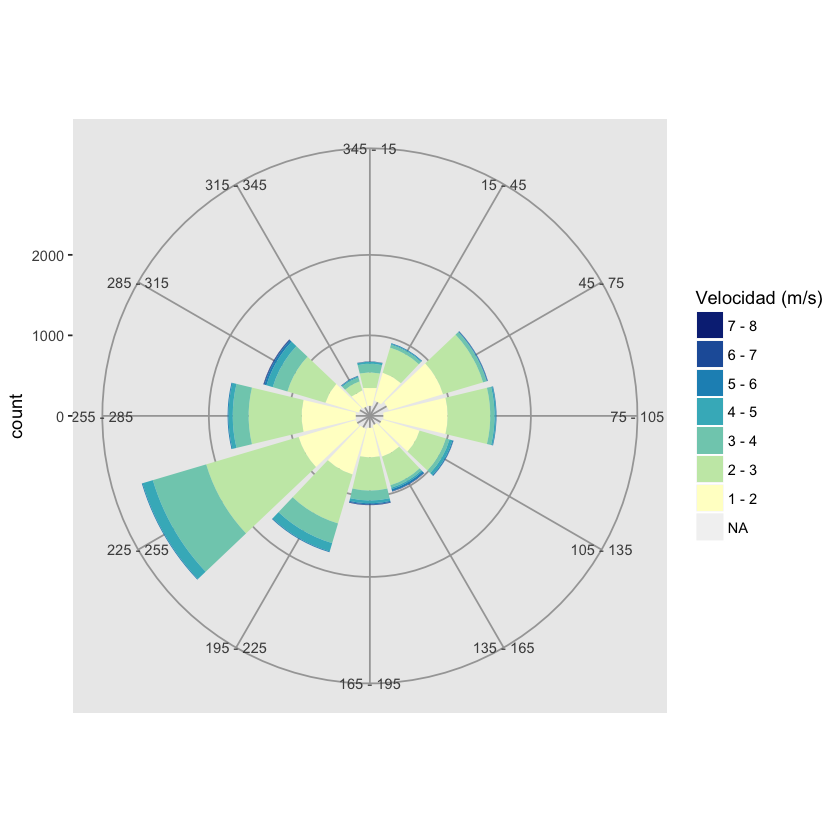

In [61]:
# try the default settings
p1 <- plot.windrose(spd = df_Wind$spd,
                   dir = df_Wind$dir)

Hadley broke my code


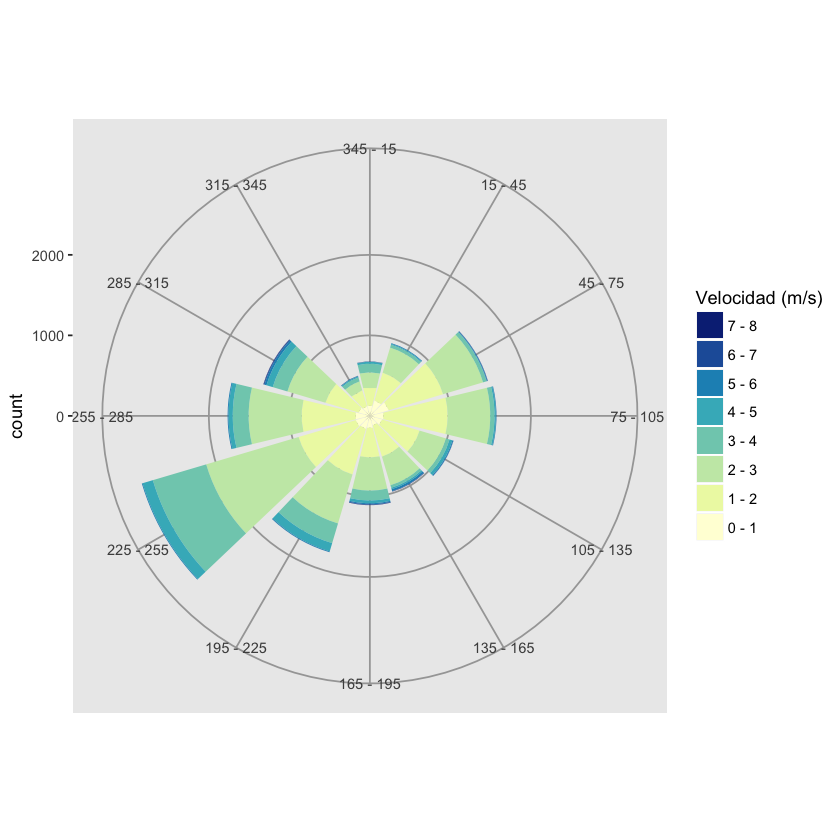

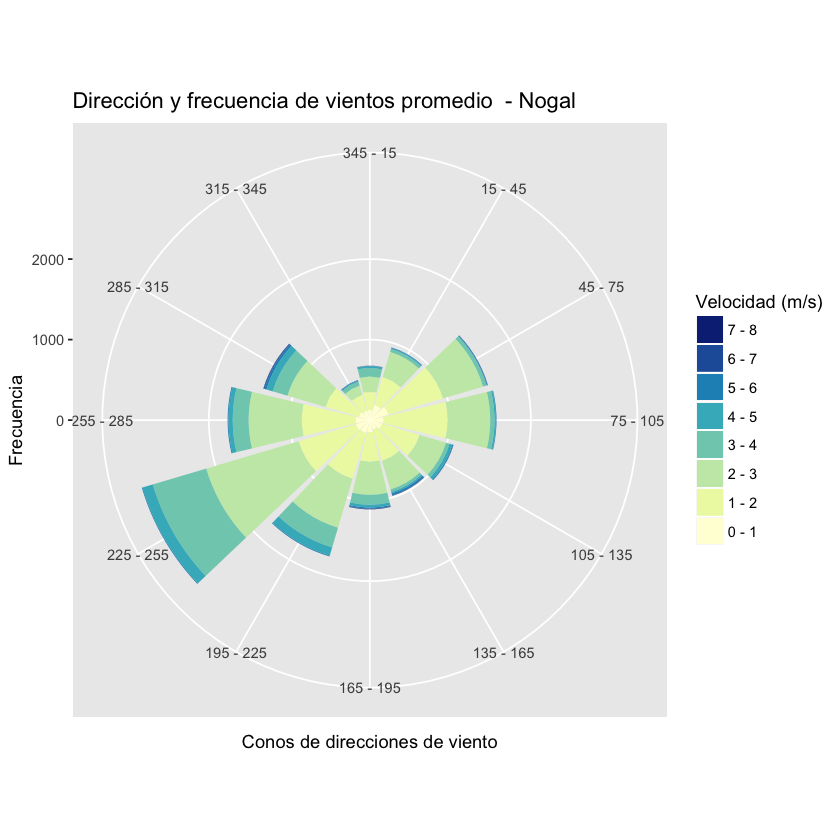

In [79]:
p2 <- plot.windrose(data=df_Wind, spd = df_Wind$spd,
                   dir = df_Wind$dir,
#                   spdseq = c(0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6)) +
                     spdseq = c(0,1,2,3,4,5,6, 7, 8)) +
                    theme_gray() +
                   ggtitle("Dirección y frecuencia de vientos promedio  - Nogal") +
                   ylab("Frecuencia")  + # for the main title 
                   xlab("Conos de direcciones de viento")
p2